In [1]:
import os
import math
import matplotlib.pyplot as plt
import torch

from utils import set_matplotlib_params

torch.set_default_dtype(torch.double)
set_matplotlib_params()

In [2]:
pwd = os.getcwd()
resdir = "results" # needs to be hardcoded

config = [f for f in os.listdir(f'{pwd}/{resdir}') if f.startswith('config')][0]
f = open(f'{pwd}/{resdir}/{config}', 'r')
content = f.read().split('\n')[:-1]
settings = [[], [], [], 0, 0, 0, 0]
for i in range(len(content)):
    equal = content[i].find('=')
    settings[i] = content[i][equal + 1:].split(' ')
    if i > 2:
        settings[i] = int(settings[i][0])
experiments, kernels, acqfs, N_REP, N_INIT, budget, expseed = settings
budget += 1 # for the initial regret

results = {e: {k: {a: {} for a in acqfs} for k in kernels} for e in experiments}

In [3]:
files = [f for f in os.listdir(f'{pwd}/{resdir}') if not (f.startswith('.') or f.startswith('config'))]
for file in files:
    exp, kernel, acqf, seed = file[:-3].split('_')
    data = torch.load(f"{pwd}/{resdir}/{file}")
    if not len(results[exp][kernel][acqf]):
        results[exp][kernel][acqf]["regrets"] = torch.zeros((budget, 0))
    results[exp][kernel][acqf]["regrets"] = torch.cat((results[exp][kernel][acqf]["regrets"], data["regrets"].unsqueeze(-1)), dim=1)

for exp in experiments:
    for kernel in kernels:
        for acqf in acqfs:
            results[exp][kernel][acqf]["mean_regret"] = results[exp][kernel][acqf]["regrets"].mean(axis=1)
            results[exp][kernel][acqf]["std_regret"] = 1.96 * results[exp][kernel][acqf]["regrets"].std(axis=1) / math.sqrt(results[exp][kernel][acqf]["regrets"].shape[1]) # 95% confidence intervals

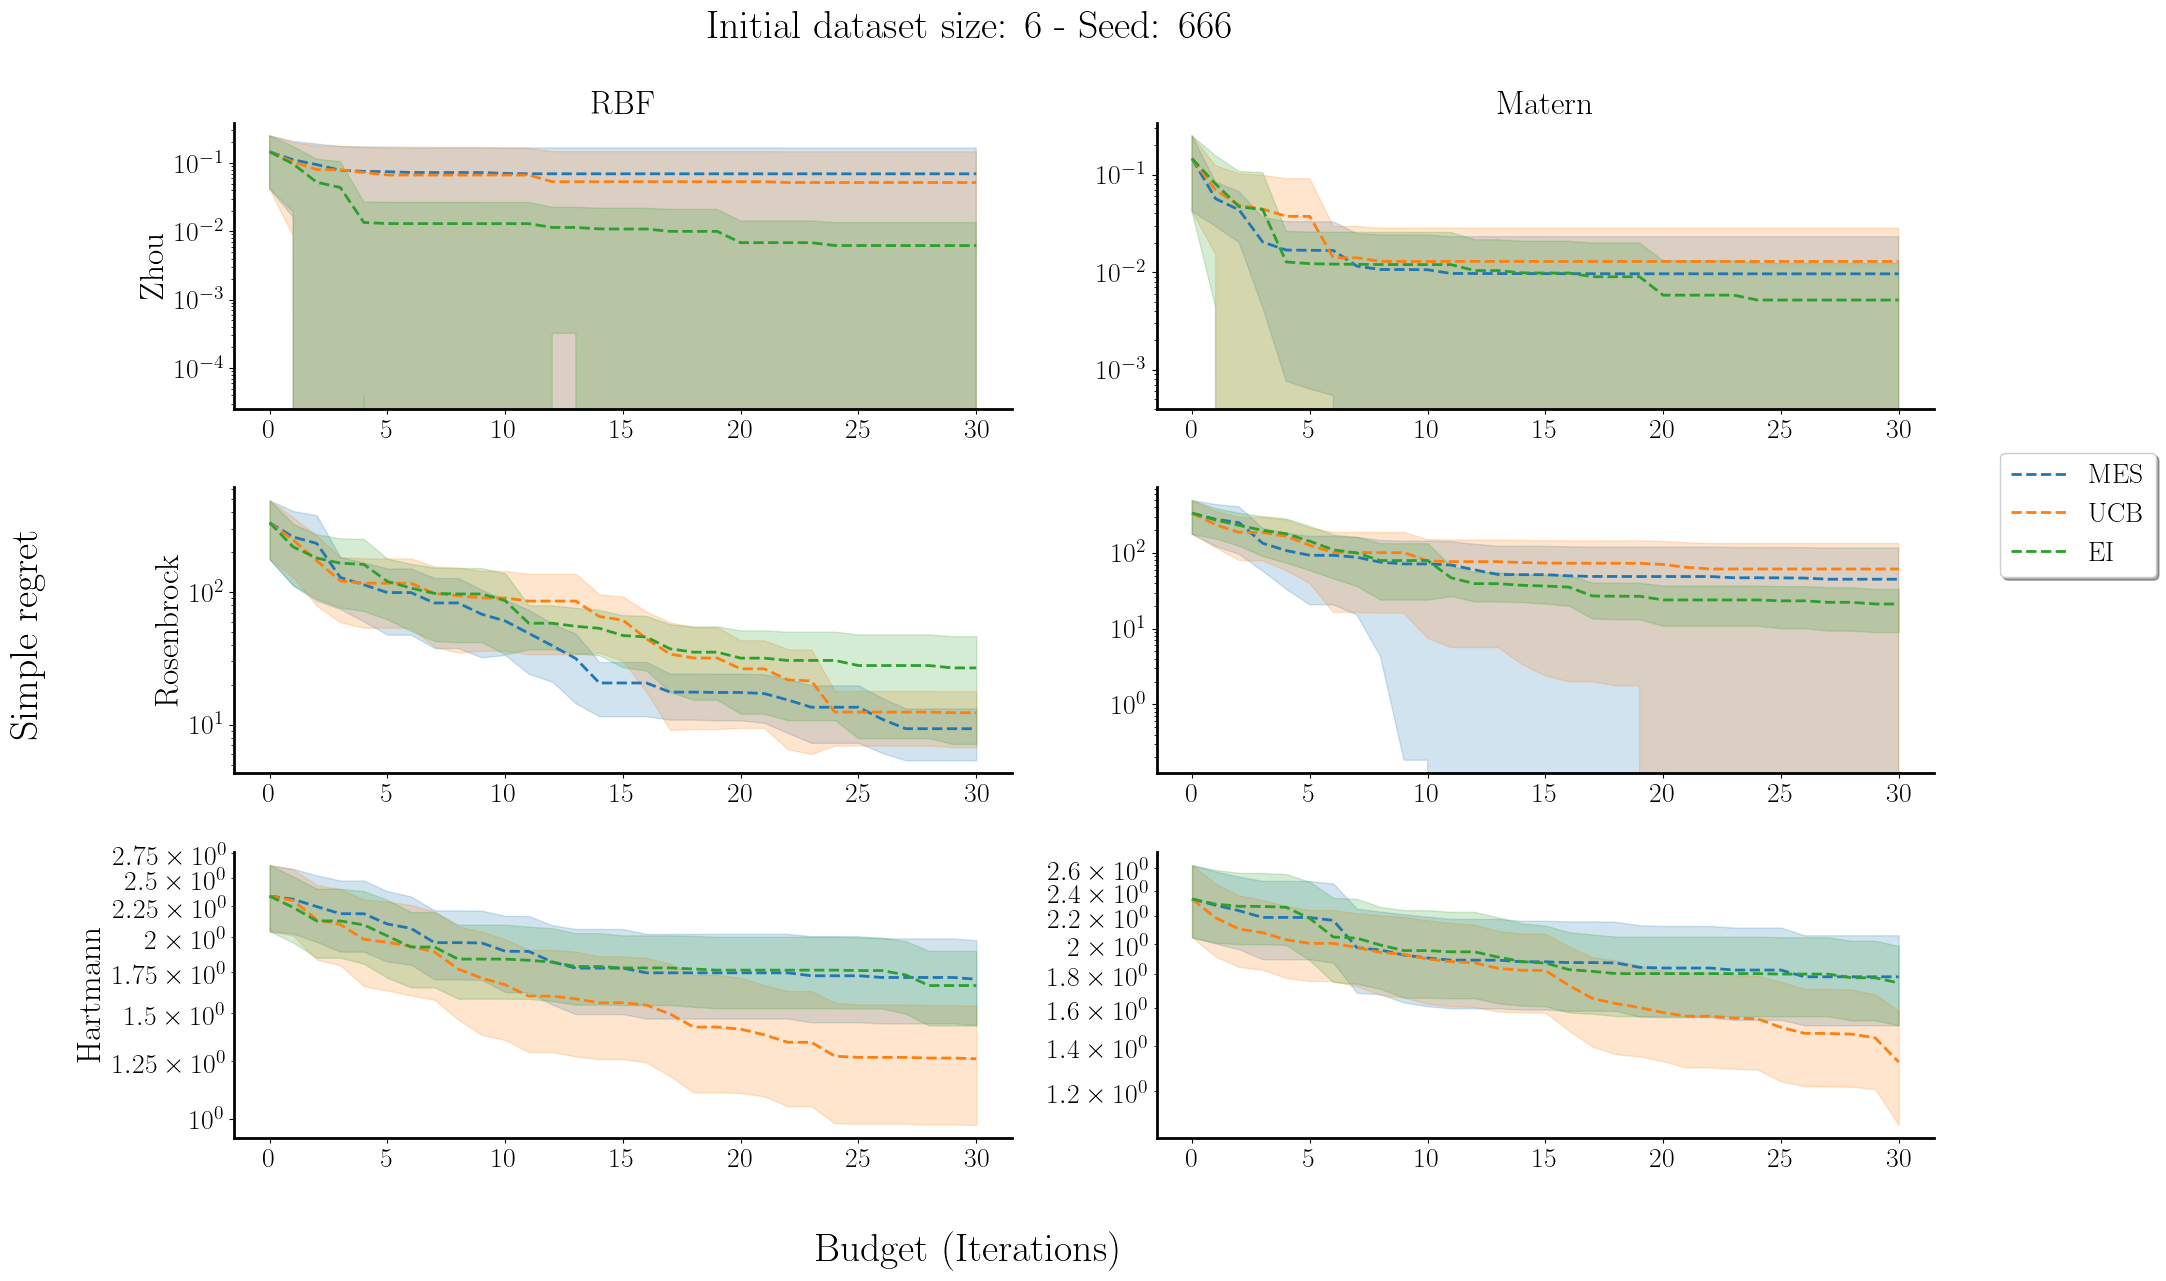

In [5]:
range_budget = [i for i in range(budget)]
fig, axes = plt.subplots(len(experiments), len(kernels), figsize=(20,13), squeeze=False)
for i, exp in enumerate(experiments):
    for j, kernel in enumerate(kernels):
        axes[0, j].set_title(kernel)
        for k, acqf in enumerate(acqfs):
            mean = results[exp][kernel][acqf]["mean_regret"]
            std = results[exp][kernel][acqf]["std_regret"]
            axes[i, j].plot(range_budget, mean, label=f"{acqf}" if (not i and not j) else None, linestyle='--')
            axes[i, j].fill_between(range_budget, mean - std, mean + std, alpha=.2, color=f"C{k}") # careful with the std bands when plotting in log scale (nonsymmetric)
        axes[i, j].set_yscale("log")
        axes[i, j].grid()
    axes[i, 0].set_ylabel(exp)
fig.legend(shadow=True, bbox_to_anchor=(1.1, .65))
fig.supxlabel('Budget (Iterations)')
fig.supylabel('Simple regret')
fig.suptitle(f'Initial dataset size: {N_INIT} - Seed: {expseed}')
fig.tight_layout()
plt.show()